# Training and Deployment:

**Multi-label audio classification fastai2 with Amazon SageMaker**

**Note - THIS IS THE GCP DEV VERSION - THE DATA FOLDER IS DIFFERENT IN SAGEMAKER, NEED TO CHANGE TO:**

```
'../data/train_curated'


The following notebook is based on the AWS demo fastai2 project (with thanks to Matt McClean for the setup instructions):

https://github.com/mattmcclean/fastai2-sagemaker-deployment-demo

We now need to train and deploy the fastai2 model on Amazon SageMaker. This notebook runs within a fastai2 kernel and environment created by a CloudFormation stack (details in the link below).

Using the steps outlined in the above demo repo the notebook will:

1. train a model locally with a SageMaker notebook instance
2. export our model and upload the model artefacts to S3 
3. deploy the model locally to the same notebook instance to test and 
4. deploy the endpoint to Amazon SageMaker to be deployed in a production setting.

**fastai2_audio**

The additional requirements of the fastai2_audio package will be dealt with below, using a clone of the following repo:

https://github.com/rbracco/fastai2_audio

The demo was run and tested by deploying an SageMaker Notebook instance as per the instructions outlined [here] (https://forums.fast.ai/t/platform-amazon-sagemaker-aws/66020).

Note - the above link is only accessible as part of the ongoing fastai course for the time being.

## GCP ONLY - INSTALL FASTAI2

In [ ]:
#Run once per session
#In Colab we need to run this as a notebook command )i.e. no '!' infront of 'pip'
#This is in comparison to shell commands i.e. with '!' infront of 'pip'
!pip install fastai2

**Download Dataset**

https://www.kaggle.com/general/74235

In [ ]:
# Install kaggle
!pip install -q kaggle

Now upload kaggle.json  API file before running next cell:

In [ ]:
# Make a directory for the json and choose the JSON file
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
 # copy JSON file
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset

! kaggle competitions download -c 'freesound-audio-tagging-2019'

In [ ]:
!unzip -d data freesound-audio-tagging-2019.zip # Unzip main data folder

In [ ]:
!unzip -d data/train_curated data/train_curated.zip; # Unzip train curated folder

In [ ]:
!unzip -d data/train_noisy data/train_noisy.zip; # Unzip train noisy folder

In [ ]:
import os
files = os.listdir('data/train_curated')
len(files)

In [ ]:
files = os.listdir('data/train_noisy')
len(files)

## Install the fastai2_audio library

We need to install the fastai2_audio library to the local kernel/environment for the analysis

Note the lack of `!pip` (that install to the root env) but rather standard `pip` (that installs to the current kernl/env)...

In [ ]:
#In Colab we need to run this as a shell command i.e. with '!' infront of 'pip'

!pip install git+https://github.com/mikful/fastai2_audio.git

In [ ]:
# Solving an OSError problem with Librosa SoundFile dependency (libsndfile)
# SageMaker/GCP Only

!conda install -c conda-forge libsndfile --yes

# Train the fastai model locally
First we will train our fastai model on the notebook instance using the kernel named `fastai2`.

The audio package analysis follows guidance given within: https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/07_Audio.ipynb

In [1]:
from fastai2.vision.all import *
from fastai2_audio.core import *
from fastai2_audio.augment import *

**Create Dataframes from csv files**

**Note: Delete Corrupted and empty files list in Kaggle Competition Note**

*The following 5 audio files in the curated train set have a wrong label, due to a bug in the file renaming process: f76181c4.wav, 77b925c2.wav, 6a1f682a.wav, c7db12aa.wav, 7752cc8a.wav*

*The audio file 1d44b0bd.wav in the curated train set was found to be corrupted (contains no signal) due to an error in format conversion.*

In [2]:
# Create train Dataframes

def create_train_curated_df(file, remove_files=[]):
    df_curated = pd.read_csv(file)
    df_curated['fname'] = 'data/train_curated/' + df_curated['fname'] 
    df_curated.set_index('fname', inplace=True)
    df_curated.loc[remove_files]
    df_curated.drop(index=remove_files, inplace=True)
    df_curated.reset_index(inplace=True)
    return df_curated

def create_train_noisy_df(file):
    df_noisy = pd.read_csv(file)
    df_noisy['fname'] = 'data/train_noisy/' + df_noisy['fname'] 
    return df_noisy


def create_combined_train_df(file_curated, file_noisy, remove_files=[]):
    df_curated = pd.read_csv(file_curated)
    df_curated['fname'] = 'data/train_curated/' + df_curated['fname'] 
    
    df_noisy = pd.read_csv(file_noisy)
    df_noisy['fname'] = 'data/train_noisy/' + df_noisy['fname'] 
    
    df_combined = df_curated.append(df_noisy)
    df_combined.set_index('fname', inplace=True)
    df_combined.loc[remove_files]
    df_combined.drop(index=remove_files, inplace=True)
    df_combined.reset_index(inplace=True)
    return df_combined

In [3]:
# Create Curated training set df

# Remove corrupt and empty files as per Kaggle

remove_files = ['f76181c4.wav', '77b925c2.wav', '6a1f682a.wav', 'c7db12aa.wav', '7752cc8a.wav', '1d44b0bd.wav']
remove_files = ['data/train_curated/' + i for i in remove_files]
df_curated = create_train_curated_df('data/train_curated.csv', remove_files=remove_files)
df_curated.head()

,fname,labels
0,data/train_curated/0006ae4e.wav,Bark
1,data/train_curated/0019ef41.wav,Raindrop
2,data/train_curated/001ec0ad.wav,Finger_snapping
3,data/train_curated/0026c7cb.wav,Run
4,data/train_curated/0026f116.wav,Finger_snapping


In [4]:
df_curated.describe()

,fname,labels
count,4964,4964
unique,4964,213
top,data/train_curated/0853b5b2.wav,Keys_jangling
freq,1,75


In [5]:
# Create train_noise Dataframe
df_noisy = create_train_noisy_df('data/train_noisy.csv')
df_noisy.head()

,fname,labels
0,data/train_noisy/00097e21.wav,Bathtub_(filling_or_washing)
1,data/train_noisy/000b6cfb.wav,Motorcycle
2,data/train_noisy/00116cd2.wav,"Marimba_and_xylophone,Glockenspiel"
3,data/train_noisy/00127d14.wav,"Water_tap_and_faucet,Sink_(filling_or_washing)"
4,data/train_noisy/0019adae.wav,Raindrop


In [6]:
df_noisy.describe()

,fname,labels
count,19815,19815
unique,19815,1168
top,data/train_noisy/3109fb7c.wav,Waves_and_surf
freq,1,291


In [7]:
# Create Combined training set df

# Remove corrupt and empty files as per Kaggle
remove_files = ['f76181c4.wav', '77b925c2.wav', '6a1f682a.wav', 'c7db12aa.wav', '7752cc8a.wav', '1d44b0bd.wav']
remove_files = ['data/train_curated/' + i for i in remove_files]
df_combined = create_combined_train_df(file_curated = 'data/train_curated.csv', 
                                       file_noisy = 'data/train_noisy.csv', 
                                       remove_files=remove_files)
df_combined.head()

,fname,labels
0,data/train_curated/0006ae4e.wav,Bark
1,data/train_curated/0019ef41.wav,Raindrop
2,data/train_curated/001ec0ad.wav,Finger_snapping
3,data/train_curated/0026c7cb.wav,Run
4,data/train_curated/0026f116.wav,Finger_snapping


In [8]:
df_combined.describe()

,fname,labels
count,24779,24779
unique,24779,1271
top,data/train_curated/0853b5b2.wav,Waves_and_surf
freq,1,362


**Now define the data paths**

First we're going to try to train with the curated train set only to see the performance. Then we can mix both the curated and noise train set to see the results.

In [9]:
fnames = df_combined['fname']

In [10]:
fnames[:5]

0    data/train_curated/0006ae4e.wav
1    data/train_curated/0019ef41.wav
2    data/train_curated/001ec0ad.wav
3    data/train_curated/0026c7cb.wav
4    data/train_curated/0026f116.wav
Name: fname, dtype: object

In [11]:
len(fnames)

24779

## Using the DataBlock API:

* We'll want to use our same transforms we used for the Pipeline
* An appropriate getter
* An appropriate labeller

The following datablock method references the new and wonderful **"Fastbook"** by fastai:

https://github.com/fastai/fastbook/blob/master/06_multicat.ipynb

and the above mentioned Audio notebook by Z Mueller.

> ### Constructing a data block
>
>How do we convert from a DataFrame object to a DataLoaders object? PyTorch and fastai have two main classes for representing and accessing a training set or validation set:
>
>* **Dataset**:: a collection which returns a tuple of your independent and dependent variable for a single item
>* **DataLoader**:: an iterator which provides a stream of mini batches, where each mini batch is a couple of a batch of independent variables and a batch of dependent variables
>
>On top of these, fastai provides two classes for bringing your training and validation sets together:
>
>* **Datasets**:: an object which contains a training Dataset and a validation Dataset
>* **DataLoaders**:: an object which contains a training DataLoader and a validation DataLoader
>
>Since a DataLoader builds on top of a Dataset, and adds additional functionality to it (collating multiple items into a mini batch), it’s often easiest to start by creating and testing Datasets, and then look at DataLoaders after that’s working.


The files in this case have multi-labels within the 'labels' column of the dataframe. 

So we will need to set the multi-labels appropriately in training.

First, we create a "datasets" object from our dataframe:


## Data Augmentation

We can use the `SpectrogramTransformer` class to prepare some transforms for us.

We need to open the audio file and convert to mel-spectrogramtensors.


In [12]:
def get_x(r): return r['fname']
def get_y(r): return r['labels'].split(',') # split labels on ','
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df_combined)
dsets.train[0]

('data/train_noisy/831d3b14.wav', ['Tap'])

In [13]:
DBMelSpec = SpectrogramTransformer(mel=True, to_db=True)

Let's take a look at our original settings:

In [14]:
cfg = AudioConfig.BasicMelSpectrogram()
aud2spec = AudioToSpec.from_cfg(cfg)
aud2spec.settings

{'mel': True,
 'to_db': True,
 'sample_rate': 16000,
 'n_fft': 400,
 'win_length': 400,
 'hop_length': 200,
 'f_min': 0.0,
 'f_max': None,
 'pad': 0,
 'n_mels': 128,
 'window_fn': <function _VariableFunctions.hann_window>,
 'wkwargs': None,
 'stype': 'power',
 'top_db': None}

In [15]:
aud2spec = DBMelSpec(f_max=8000, f_min=20, n_mels=128, n_fft=1024, hop_length=128, top_db=90)

For our transforms, we'll use:
* `RemoveSilence`
  * Splits a signal at points of silence more than 2 * `pad_ms` (default is 20)
* `CropSignal`
  * Crops a signal by `duration` and adds padding if needed
* `aud2spec`
  * Our `SpectrogramTransformer` with parameters
* `MaskTime`
  * Wrapper for `MaskFre`, which applies `einsum` operations
* `MaskFreq`
  * [SpecAugment Time Masking](https://arxiv.org/abs/1904.08779)

Let's look a bit more at the padding `CropSignal` uses:

There are three different types:
* `AudioPadTypes.Zeros`: The default, random zeros before and after
* `AudioPadType.Repeat`: Repeat the signal until proper length (great for coustic scene classification and voice recognition, terrible for speech recognition)
* `AudioPadtype.ZerosAfter`: This is the default for many other libraries, just pad with zeros until you get the specified length.

In [16]:
item_tfms = [RemoveSilence(), CropSignal(4000, pad_mode='Repeat'), aud2spec, MaskTime(num_masks=1, size=100), MaskFreq(num_masks=1, size=10)]

**Note: After some testing with different numbers of frequency masks and sizes, the above settings were found to be optimal for the Curated Train Set.**

Now let's build our `DataBlock`

The block type can be used here, combining the `AudioBlock` for the audio transforms and the `MultiCategoryBlock` for multi-label classification. This type of block expects to receive a list of strings for the different labels.

In [17]:
dblock = DataBlock(blocks=(AudioBlock, MultiCategoryBlock),
                    splitter=RandomSplitter(),
                    get_x=get_x,
                    get_y=get_y,
                    item_tfms = item_tfms)

# dsets = dblock.datasets(df_curated)
dsets = dblock.datasets(df_combined)
dsets.train[0]

(AudioTensor([[-0.0133, -0.0136, -0.0135,  ...,  0.0033,  0.0074,  0.0049]]),
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]))

In [18]:
# Let's see what size the training and validation dataset items have

xt,yt = dsets.train[0] # xt = AudioTensor, yt = TensorMultiCategory
xt.shape,yt.shape,len(dsets.train) # show shapes and dataset size (no. items)

(torch.Size([1, 17640]), torch.Size([80]), 19824)

In [19]:
xv,yv = dsets.valid[0]
xv.shape,yv.shape,len(dsets.valid)

(torch.Size([1, 661500]), torch.Size([80]), 4955)

In the above we can see the created audiotensor and the one-hot encoded labels: TensorMultiCategory.

Let’s check what the categories represent for this example (we are using the convenient torch.where function, which tells us all of the indices where our condition is true or false). 

With numpy arrays, PyTorch tensors, and fastai’s L class, you can index directly using a list or vector, which makes a lot of code (such as this example) much clearer and more concise.

In [20]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['Printer']

**Now we define our DataLoader**

A `DataLoader` collates the items from a `Dataset` into a mini batch. This is a tuple of tensors, where each tensor simply stacks the items from that location in the `Dataset` item. Now that we have confirmed that the individual items look okay there's one more step we need to ensure we can create our DataLoaders.

In [21]:
dls = dblock.dataloaders(df_combined, bs=32)
# dls = dblock.dataloaders(df_noisy, bs=64)

In [22]:
# Let's check our batch shape
dls.one_batch()[0].shape

torch.Size([32, 1, 128, 1379])

Let's look at some augmented data:

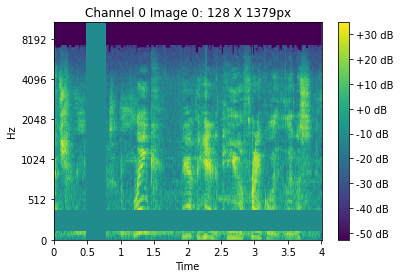

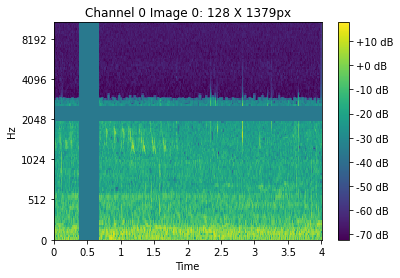

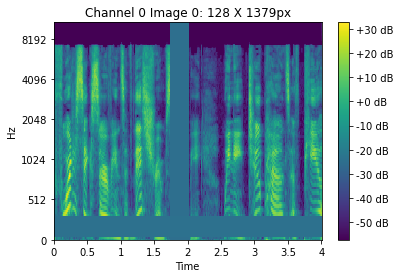

Frying_(food)
Chewing_and_mastication
Sigh


In [23]:
dls.show_batch(max_n=3)

## Training

Now that we have our `Dataloaders`, we need to make a model. We'll make a function that changes a `Learner`'s first layer to accept a 1 channel input.

Let's make an audio_learner function which is similar to a cnn_learner. In addition, the learner will need the Binary Cross Entropy Loss, so we will need to combine both the approach from the fastai multicat notebook:

https://github.com/fastai/fastbook/blob/master/06_multicat.ipynb

and the fastai2 audio learner creation.

This will need the following steps:



1.   Create a standard CNN Learner
2.   Get the activation sizes from a single mini-batch
3. Pass the activation sizes to the BCELoss Function
4. Pass the BCE Loss function to the `audiolearner` function, which augments the Leaner to accept a single channel input




**Note on Multi-category Loss Function**

Fastbook:

>We also saw that the model in a Learner is generally an object of a class inheriting from nn.Module, and that you can call it using parentheses and it will return the activations of a model. You should pass it your independent variable, as a mini batch. We can try it out by grabbing a mini batch from our DataLoader, and then passing it to the model:

>Note that because we have a one-hot encoded dependent variable, we can't directly use nll_loss or softmax (and therefore we can't use cross_entropy).

>Normally for one-hot encoded targets you'll want F.binary_cross_entropy_with_logits (or nn.BCEWithLogitsLoss), which do both sigmoid and binary cross entropy in a single function, as in our example above.

***With a standard learner, we don't normally need to tell fastai to use this loss function since it will be automatically chosen for us using the DataLoaders recognising multiple category labels. However, as we are creating an audio_learner, we need to provide the loss function to the audio_learner() function defined above.***

>One change compared to the last chapter is the metric we use: since we are in a multilabel problem, we can't use the accuracy function

>The class predicted was the one with the highest activation (this is what argmax does). Here it doesn't work because we could have more than one prediction on a single image. After applying the sigmoid to our activations (to make them between 0 and 1), we need to decide which ones are 0s and which ones are 1s by picking a threshold. Each value above the threshold will be considered as a 1, and each value lower than the threshold will be considered a 0. 

>If we pass accuracy_multi directly as a metric, it will use the default value for threshold, which is 0.5. We might want to adjust that default and create a new version of accuracy_multi that has a different default. 

>Picking a threshold is important. If you pick a threshold that's too low, you'll often be failing to select correctly labelled objects. If you pick a threshold that's too high, you'll often be selecting correctly labelled objects. We can see this by changing our metric, and then calling validate, which returns the validation loss and metrics. 

In this case, we're going to use BCEWithLogitsLossFlat():

```"Same as `nn.CrossEntropyLoss`, but flattens input and target."```

say the fastai docs - double check.

Also, we change the output to be 80 neurons to match the label amount.


## Using an LWL-wrap Metric

For the Kaggle competition the metric used was lwl wrap:

_The primary competition metric will be label-weighted label-ranking average precision (lwlrap, pronounced "Lol wrap"). This measures the average precision of retrieving a ranked list of relevant labels for each test clip (i.e., the system ranks all the available labels, then the precisions of the ranked lists down to each true label are averaged). This is a generalization of the mean reciprocal rank measure (used in last year’s edition of the competition) for the case where there can be multiple true labels per test item. The novel "label-weighted" part means that the overall score is the average over all the labels in the test set, where each label receives equal weight (by contrast, plain lrap gives each test item equal weight, thereby discounting the contribution of individual labels when they appear on the same item as multiple other labels)._

_We use label weighting because it allows per-class values to be calculated, and still have the overall metric be expressed as simple average of the per-class metrics (weighted by each label's prior in the test set). For participant’s convenience, a Python implementation of lwlrap is provided in [this](https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8) public Google Colab._

An implementation for fastai is also outlined within this competition kernel, used below:

https://www.kaggle.com/daisukelab/cnn-2d-basic-solution-powered-by-fast-ai


**Note: we will also need to experiment with the spectrogram augmentation**

In [24]:
# from official code https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8#scrollTo=cRCaCIb9oguU
def _one_sample_positive_class_precisions(scores, truth):
    """Calculate precisions for each true class for a single sample.

    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indicating which classes are true.

    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    # Only calculate precisions if there are some true classes.
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    # Retrieval list of classes for this sample.
    retrieved_classes = np.argsort(scores)[::-1]
    # class_rankings[top_scoring_class_index] == 0 etc.
    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)
    # Which of these is a true label?
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    # Num hits for every truncated retrieval list.
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    # Precision of retrieval list truncated at each hit, in order of pos_labels.
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits


def calculate_per_class_lwlrap(truth, scores):
    """Calculate label-weighted label-ranking average precision.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    # Space to store a distinct precision value for each class on each sample.
    # Only the classes that are true for each sample will be filled in.
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    # Form average of each column, i.e. all the precisions assigned to labels in
    # a particular class.
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
    #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
    #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
    #                = np.sum(per_class_lwlrap * weight_per_class)
    return per_class_lwlrap, weight_per_class


# Wrapper for fast.ai library
def lwlrap(scores, truth, **kwargs):
    score, weight = calculate_per_class_lwlrap(to_np(truth), to_np(scores))
    return torch.Tensor([(score * weight).sum()])

# Staged Training Approach

1. Stage 1 - train on curated_train only + fine tune. Freeze again before next stage.
2. Stage 2 - train and validation on noisy_train + fine-tune.
3. Stage 3 - Inference on Test test set. Submit to kaggle to see results.

## Stage 1

In [25]:
def get_x(r): return r['fname']
def get_y(r): return r['labels'].split(',') # split labels on ','

dblock = DataBlock(blocks=(AudioBlock, MultiCategoryBlock),
                    splitter=RandomSplitter(valid_pct=0.01, seed=42), # using tiny valid set, just to check. Ensure reproducibility with seed
                    get_x=get_x,
                    get_y=get_y,
                    item_tfms = item_tfms)

dsets = dblock.datasets(df_curated)
dsets.train[0]

(AudioTensor([[ 0.0000e+00, -3.0518e-05,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]]),
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]))

In [26]:
dls = dblock.dataloaders(df_curated, bs=32)

In [30]:
## Pretrained 1-channel input xresnet50 with lwl-wrap metric

# on Curated achieves 77.8% lwl-wrap after train (10 epochs) and 80% after fine-tuning (10 epochs)
# Augmentations:
# DBMelSpec(n_mels=128, f_max=8000, n_fft=1024, hop_length=128, top_db=100)
#[RemoveSilence(), CropSignal(4000, pad_mode='Repeat'), aud2spec, MaskTime(size=30), MaskFreq(size=10)]


# Custom cnn model created from 1 channel input pretrained resnet50
# torch.nn.BCEWithLogitsLoss() = Binary Cross Entropy Loss from pytorch
# accuracy_multi for multi label
# .to_fp16() for mixed-precision training

model = create_cnn_model(xresnet50, n_in=1, n_out=80) #create custom model with 1 input channel and 80 output nodes

learn = Learner(dls, model, BCEWithLogitsLossFlat(), metrics=[lwlrap]).to_fp16() # pass custom model to Learner

SuggestedLRs(lr_min=0.33113112449646, lr_steep=2.7542285919189453)

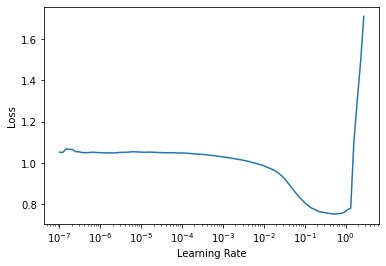

In [31]:
# find the learning rate
learn.lr_find()

In [32]:
# fit with one_cyle learning rate policy
learn.fit_one_cycle(10, 4e-2)

epoch,train_loss,valid_loss,lwlrap,time
0,0.160001,0.083011,0.136002,01:41
1,0.084493,0.061802,0.230116,01:41
2,0.066440,0.063905,0.183771,01:41
3,0.064377,0.076081,0.159367,01:41
4,0.061002,0.056014,0.282133,01:41
5,0.055174,0.044678,0.469718,01:41
6,0.048934,0.035662,0.602338,01:41
7,0.041731,0.030007,0.699167,01:41
8,0.037802,0.026958,0.759344,01:41
9,0.034515,0.026535,0.787064,01:41


In [33]:
# Save the stage 1 model to allow quick fine tuning experimentation
learn.save('xresnet50-stage-1-model-curated-frozen')

Now let's unfreeze the base model and train on the whole network:

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=2.75422871709452e-06)

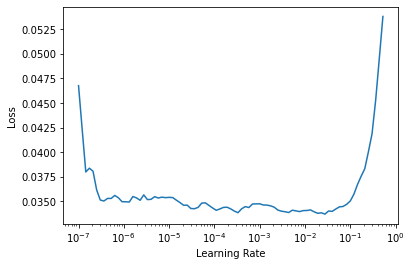

In [34]:
learn.unfreeze()
learn.lr_find()

In [35]:
learn.fit_one_cycle(10, lr_max=slice(3e-5,3e-3))

epoch,train_loss,valid_loss,lwlrap,time
0,0.033712,0.025769,0.803715,01:41
1,0.034423,0.025337,0.794640,01:41
2,0.034027,0.024991,0.803438,01:41
3,0.033342,0.024413,0.789025,01:41
4,0.031464,0.024061,0.826310,01:41
5,0.030797,0.021494,0.828414,01:41
6,0.030222,0.022914,0.812671,01:41
7,0.029228,0.022603,0.828058,01:41
8,0.028673,0.021759,0.831450,01:41
9,0.027791,0.023231,0.821655,01:41


In [38]:
# Freeze and Save the stage 2 model after fine-tuning
learn.freeze()
learn.save('xresnet50-stage-2-model-curated-tuned-frozen')

## Stage 2

In [39]:
# define new noisy data subset using RandomSubsetSplitter if wanting smaller data subet

def get_x(r): return r['fname']
def get_y(r): return r['labels'].split(',') # split labels on ','

dblock = DataBlock(blocks=(AudioBlock, MultiCategoryBlock),
                    splitter=RandomSubsetSplitter(train_sz=0.8, valid_sz=0.2, seed=42), # split into smaller subsets for faster experimentation, reproducibility with seed
                    get_x=get_x,
                    get_y=get_y,
                    item_tfms = item_tfms)

dsets = dblock.datasets(df_noisy)
dsets.train[0]

(AudioTensor([[-9.1553e-05, -6.1035e-05, -9.1553e-05,  ..., -4.2725e-03,
          -6.0120e-03, -6.9275e-03]]),
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]))

In [40]:
dls = dblock.dataloaders(df_noisy, bs=32)

In [44]:
# Load weights from saved model and pass new noisy data

model = create_cnn_model(xresnet50, n_in=1, n_out=80) #create custom model with 1 input channel and 80 output nodes

learn = Learner(dls, model, BCEWithLogitsLossFlat(), metrics=[lwlrap]).to_fp16() # pass custom model to Learner

learn = learn.load('xresnet50-stage-2-model-curated-tuned-frozen')

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=2.0892961401841603e-05)

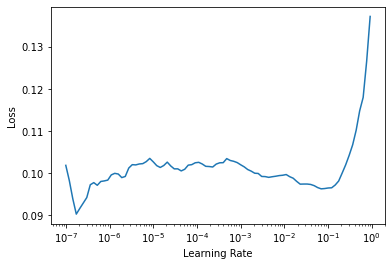

In [45]:
# find the learning rate
learn.lr_find()

In [ ]:
# fit frozen (base) network with one_cycle learning rate policy
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,lwlrap,time


In [ ]:
# Save the stage 3 model to allow quick fine tuning experimentation
learn.save('xresnet50-stage-3-model-noisy-frozen')

Now let's unfreeze the base model again and train on the whole network:

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5,1e-3))

In [ ]:
# Save the stage 4 model
learn.save('xresnet50-stage-4-model-noisy-tuned-frozen')

## Test model on Test set and upload to Kaggle to see results

In [ ]:
# create Test set data
# need to unzip file and create dataframe then dataloader






In [ ]:
# Load weights from saved model and pass test set data

model = create_cnn_model(xresnet50, n_in=1, n_out=80) #create custom model with 1 input channel and 80 output nodes

learn = Learner(dls, model, BCEWithLogitsLossFlat(), metrics=[lwlrap]).to_fp16() # pass custom model to Learner

learn = learn.load('xresnet50-stage-2-model-curated-tuned-frozen')

In [ ]:
learn.export()

In [ ]:
learn.predict()

## Training results from Dataset 2 - Subset of Noisy dataset

In [ ]:
# define data subset using RandomSubsetSplitter

def get_x(r): return r['fname']
def get_y(r): return r['labels'].split(',') # split labels on ','

dblock = DataBlock(blocks=(AudioBlock, MultiCategoryBlock),
                    splitter=RandomSubsetSplitter(train_sz=0.2, valid_sz=0.05, seed=42), # split into smaller subsets for faster experimentation, reproducibility with seed
                    get_x=get_x,
                    get_y=get_y,
                    item_tfms = item_tfms)

dsets = dblock.datasets(df_noisy)
dsets.train[0]

In [ ]:
dls = dblock.dataloaders(df_noisy, bs=32)

In [ ]:
### OPTION 1 - Pretrained 1-channel input xresnet50 with lwl-wrap metric

# !!Worse than xse_resnet50()

# Achieves 42% lwl-wrap after train (10 epochs) + fine-tune (10 epochs)
# Augmentations:
# DBMelSpec(n_mels=128, f_max=8000, n_fft=1024, hop_length=128, top_db=100)
#[RemoveSilence(), CropSignal(2000, pad_mode='Repeat'), aud2spec, MaskTime(size=30), MaskFreq(size=10)]


# Custom cnn model created from 1 channel input pretrained resnet50
# torch.nn.BCEWithLogitsLoss() = Binary Cross Entropy Loss from pytorch
# accuracy_multi for multi label
# .to_fp16() for mixed-precision training

model = create_cnn_model(xresnet50, n_in=1, n_out=80) #create custom model with 1 input channel and 80 output nodes

learn = Learner(dls, model, BCEWithLogitsLossFlat(), metrics=[lwlrap]).to_fp16() # pass custom model to Learner

In [ ]:
### OPTION 2 - Pretrained 1-channel input xse_resnet50 with lwl-wrap metric

# Achieves 42% after train (10 epochs) no fine-tune - much worse than curated train set-- augmentations?
# Augmentation:
# Same as option 1

# Custom cnn model created from 1 channel input pretrained resnet50
# torch.nn.BCEWithLogitsLoss() = Binary Cross Entropy Loss from pytorch
# accuracy_multi for multi label
# .to_fp16() for mixed-precision training

learn = Learner(dls, xse_resnet50(c_in=1, n_out=80, pretrained=True), BCEWithLogitsLossFlat(), metrics=[lwlrap]).to_fp16() # pass custom model to Learner

In [ ]:
# find the learning rate
learn.lr_find()

In [ ]:
# fit with one_cyle learning rate policy
learn.fit_one_cycle(10, 4e-2)

In [ ]:
# Save the stage 1 model to allow quick fine tuning experimentation
learn.save('noisy-subset-stage-1-model')

Now let's unfreeze the base model and train on the whole network:

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-4,1e-3))

In [ ]:
# Save the stage 2 model after fine-tuning
learn.save('noisy-subset-datasets-stage-2')

## Comparison of model performance and analysis


New approach

1. Stage 1 - Train pretrained xresnet50 on curated train set frozen + then finetune. Freeze base.
2. Stage 2 - Split noisy train set into train + valid - frozen train and finetune
3. Stage 3 - Test on Test Set - upload to Kaggle to see results

**Performance??**







As can be seen from the above results, with the same model and augmentation parameters we get the following results:

* **Curated Train Data** - 77.5%
* **Noisy Train Data** - approx. 52%
* **Combined data - Curated + Noisy** - approx. 61%


As can be seen from the above, the best performance was acheived with the ... dataset and the worst with the ... dataset. Therefore it is presumed the Train and Noisy datasets are quite mismatched in their distributions. 



_"There may be many technical reasons for your observations; the most likely is that the two datasets do not have the same distributions even though they were provided by the same source (did you perform a Wilcoxon Mann Whitney hypothesis test of identity of the distributions? Did you try to train classifiers on dataset 1 an test them on dataset 2, and conversely thain on dataset 2 and test on dataset 1); or, there is a problem with the method you use for selecting the hyperparameters of the classifiers; or, the estimation of the performance by cross-validation is inaccurate for the small dataset (10-fold cross-validation on dataset 1 gives small validation tests; did you look at the variance of the validation test performances? Did you try leave-one-out cross-validation?); or, you have a class imbalance problem (your results on dataset 2 are just slightly above random classification assuming that the classes are balanced). This is not an exhaustive list; you need to examine critically each step and each assumption of your methodology."_
